The Pokemon dataset is a complete listing of all Pokemon species as of mid-2016, containing data about their type and statistics. Considering how diverse Pokemon are, it's worthwhile analyzing this datset to identify any insights regarding the design of new Pokemon, how the game is balanced and to potentially assist players in selecting the best Pokemon, if there exists one. And having been a fervent Pokemon fan as a kid, I'm also dreadfully curious!
<!-- TEASER_END -->

While one could easily analyze the dataset using Excel, this software isn't very handy for cleaning messy datasets or telling a story. In addition, Excel is proprietary/closed, not capable of processing large data sets (limited to 1,048,576 rows), and its analyses lack repeatability and transparency. One solution is to use [Jupyter notebooks](http://jupyter.org/) for exploratory analysis combined with Python's open-source libraries: [pandas](http://pandas.pydata.org/pandas-docs/stable/index.html) for data analysis and [seaborn](http://seaborn.pydata.org/index.html) for high-level visualizations.

The Pokemon dataset was made available on [Kaggle](https://www.kaggle.com/abcsds/pokemon). Let's begin by loading it and taking a peek inside.

In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the dataset into a DataFrame
df = pd.read_csv('data/pokemon.csv')

# Show the first five rows
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [2]:
# Show a summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
#             800 non-null int64
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Here's a quick description of each column, taken from Kaggle:
- ```#``` - Pokedex entry number of the Pokemon
- ```Name``` - name of the Pokemon
- ```Type 1``` - each Pokemon has a type, this determines weakness/resistance to attacks [referred to as the primary type]
- ```Type 2``` - some Pokemon are dual type and have 2 [referred to as the secondary type]
- ```Total``` - sum of all stats that come after this, a general guide to how strong a Pokemon is
- ```HP``` - hit points, or health, defines how much damage a Pokemon can withstand before fainting
- ```Attack``` - the base modifier for normal attacks
- ```Defense``` - the base damage resistance against normal attacks
- ```Sp. Atk``` - special attack, the base modifier for special attacks
- ```Sp. Def``` - the base damage resistance against special attacks
- ```Speed``` - determines which Pokemon attacks first each round
- ```Generation``` - refers to which grouping/game series the Pokemon was released in
- ```Legendary``` - a boolean that identifies whether the Pokemon is legendary

# Table of contents

1. [Cleaning the dataset](#cell0)
2. [How are Pokemon numbers distributed across generations?](#cell1)
3. [What are the most common types of Pokemon?](#cell2)
4. [What are the strongest and weakest Pokemon species?](#cell3)
5. [What are the strongest and weakest types of Pokemon?](#cell4)
6. [Do any types of Pokemon excel at certain statistics over others?](#cell5)
7. [Are any of the statistics correlated?](#cell6)
8. [Considerations regarding the results](#cell7)

<a id="cell0"></a>
# 1. Cleaning the dataset

One of our first priorities is ensuring the datset is [tidy](https://www.jstatsoft.org/article/view/v059i10), meaning each column should  represent a single variable and each row represent a single data point (Pokemon species in this case). According to [Bulbapedia](http://bulbapedia.bulbagarden.net/wiki/Generation), there are only 721 Pokemon species by generation 6, which suggests that there may be duplicate rows in our dataset. In addition, our initial inspection also revealed some Pokemon have missing values for ```Type 2```, which confirms that not all Pokemon have a secondary type; we have to account for these missing values. We also notice the dataset has two observational units: the Pokemon's identity and statistics, which should be normalized into two tables to prevent future inconsistencies. 

But before any rigorous cleaning, let's do some housekeeping.

In [3]:
# Rename the # column to id
df.rename(columns={'#': 'id'}, inplace=True)

# Convert all column labels to lower case
df.columns = df.columns.str.lower()

Now let's take a look at any duplicated rows via the ```id``` column.

In [4]:
# Show all Pokemon with duplicated id values
df[df.duplicated('id', keep=False)].head()

,id,name,type 1,type 2,total,hp,attack,defense,sp. atk,sp. def,speed,generation,legendary
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


We can clearly see that some Pokemon have multiple "forms" but share the same ```id``` value. Since these additional forms represent the same Pokemon species albeit with different statistics, let's mindfully exclude these duplicates in our analysis except for the first instance.

In [5]:
# Remove any Pokemon with duplicated id numbers except for the first instance
df.drop_duplicates('id', keep='first', inplace=True)

Since all Pokemon species have a primary type but not necessarily a secondary type, we'll fill in these missing values with a placeholder.

In [6]:
# Replace any missing values in type 2 with 'None'
df['type 2'].fillna(value='None', inplace=True)

The dataset contains both information regarding the identity and statistics of each Pokemon species; therefore, let's separate these two observational units into separate tables.

In [7]:
# Select only the identity-related columns from original dataset and store them in 
# new table called pokedex
pokedex = df[['id', 'name', 'type 1', 'type 2', 'generation', 'legendary']]

# Join the original dataset with the pokedex table to generate a new table called
# statistics
statistics = pd.merge(
    df,
    pokedex,
    on='id'
).loc[:, ['id', 'hp', 'attack', 'defense', 'sp. atk', 'sp. def', 'speed',
          'total']]

Now let's review the two tables along with our newly made changes.

In [8]:
pokedex.head()

,id,name,type 1,type 2,generation,legendary
0,1,Bulbasaur,Grass,Poison,1,False
1,2,Ivysaur,Grass,Poison,1,False
2,3,Venusaur,Grass,Poison,1,False
4,4,Charmander,Fire,None,1,False
5,5,Charmeleon,Fire,None,1,False


In [9]:
pokedex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 0 to 799
Data columns (total 6 columns):
id            721 non-null int64
name          721 non-null object
type 1        721 non-null object
type 2        721 non-null object
generation    721 non-null int64
legendary     721 non-null bool
dtypes: bool(1), int64(2), object(3)
memory usage: 34.5+ KB


In [10]:
statistics.head()

,id,hp,attack,defense,sp. atk,sp. def,speed,total
0,1,45,49,49,65,65,45,318
1,2,60,62,63,80,80,60,405
2,3,80,82,83,100,100,80,525
3,4,39,52,43,60,50,65,309
4,5,58,64,58,80,65,80,405


In [11]:
statistics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 0 to 720
Data columns (total 8 columns):
id         721 non-null int64
hp         721 non-null int64
attack     721 non-null int64
defense    721 non-null int64
sp. atk    721 non-null int64
sp. def    721 non-null int64
speed      721 non-null int64
total      721 non-null int64
dtypes: int64(8)
memory usage: 50.7 KB


Everything looks good and the dataset is tidy! It's now time to get to those questions.

<a id="cell1"></a>
# 2. How are Pokemon numbers distributed across generations?

We'll start by taking a look at the total number of Pokemon in each generation.

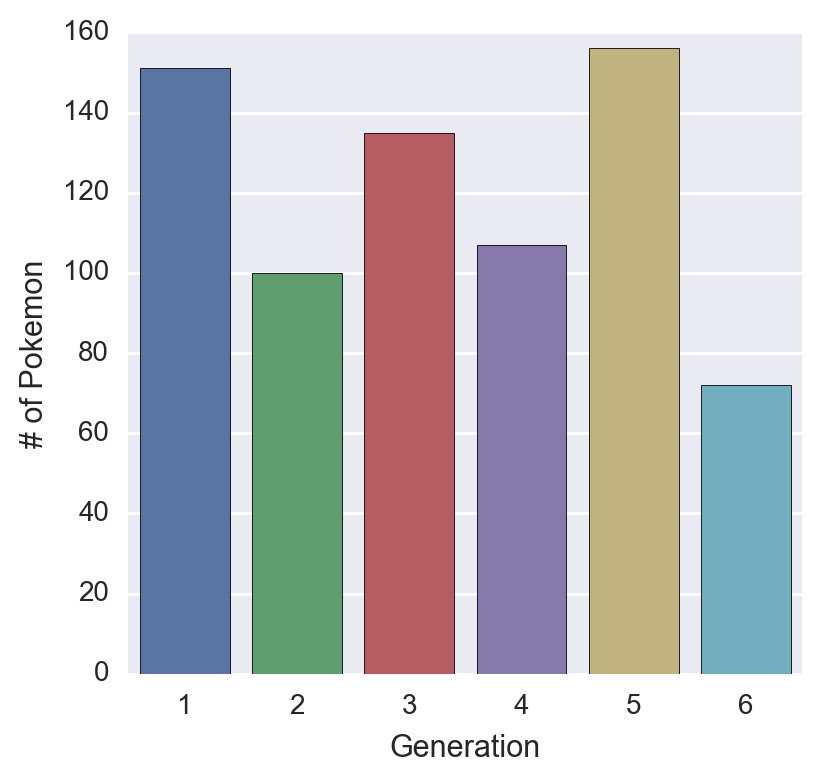

In [12]:
# Display a categorial histogram and label axes
sns.factorplot(
    x='generation', 
    data=pokedex, 
    kind='count'
).set_axis_labels('Generation', '# of Pokemon');

There doesn't seem to be a trend across generations; however, even-numbered generations introduced fewer Pokemon as compared to the odd-numbered generations.

Let's dig a bit deeper and examine the distribution of primary types of Pokemon across generations.

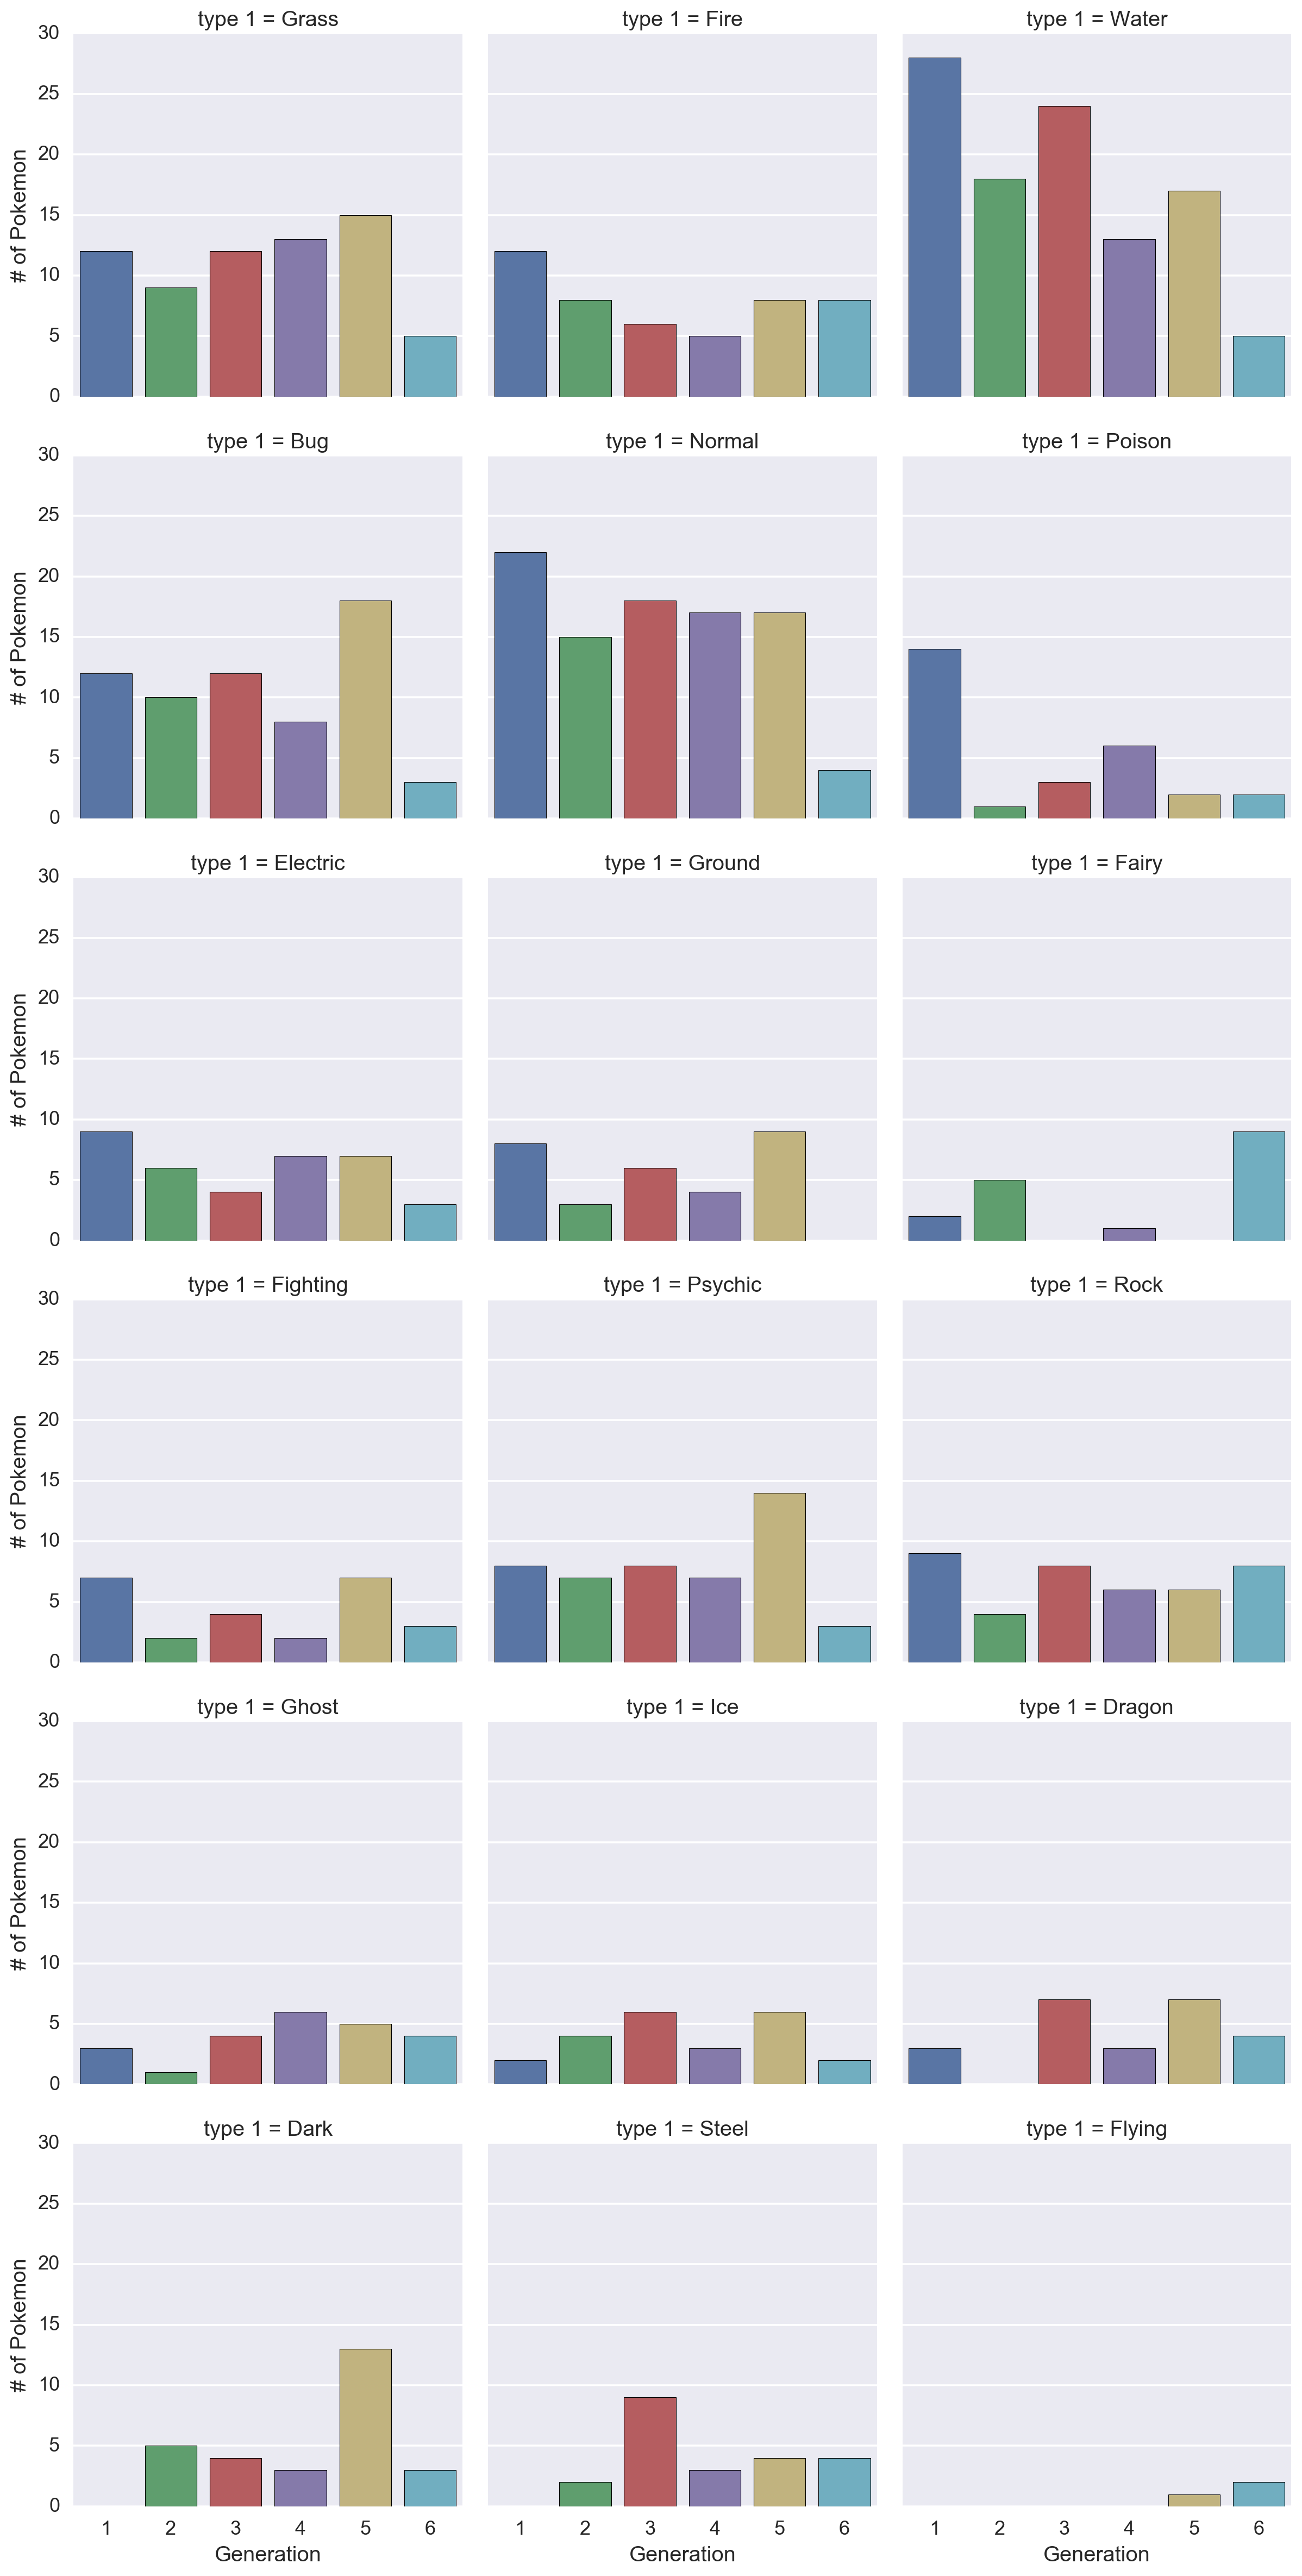

In [13]:
# Set the font scale for better readability 
sns.set_context('talk')

# Display a categorical histogram faceted by primary type and label axes
sns.factorplot(
    x='generation',
    data=pokedex,
    col='type 1',
    kind='count',
    col_wrap=3
).set_axis_labels('Generation', '# of Pokemon');

Most types of Pokemon have similar counts across generations but a few interesting tidbits standout:
- Generation 1 included quite a few Poison-type Pokemon but they've been more or less an afterthought in later generations.
- Generation 5 received a surge of new Psychic-type and Dark-type Pokemon, while Steel-type Pokemon received a large boost in generation 3.
- Normal-type Pokemon had a strong presence in every generation except generation 6.

<a id="cell2"></a>
# 3. What are the most common types of Pokemon?

It's been a long time since I've played the Pokemon games so let's begin by investigating if there are any unique primary or secondary Pokemon types, or if they simply share the same ones.

In [14]:
# Identify the primary types that are also secondary types, and vice versa
unique_type1 = np.setdiff1d(pokedex['type 1'], pokedex['type 2'])
unique_type2 = np.setdiff1d(pokedex['type 2'], pokedex['type 1'])

# Display any unique primary types
print('Unique Type 1: ', end='')
if unique_type1.size == 0:
    print('No unique types')
else:
    for u in unique_type1:
        print(u)

# Display any unique secondary types
print('Unique Type 2: ', end='')
if unique_type2.size == 0:
    print('No unique types')
else:
    for u in unique_type2:
        print(u)

Unique Type 1: No unique types
Unique Type 2: None


There are no unique primary or secondary types but as noted earlier, some Pokemon species don't have a secondary type, as pointed out by the unique secondary type value of 'None'. Now let's count the total number of primary and secondary types.

In [15]:
# Group by primary or secondary type, and compute the total number in each group
type1, type2 = pokedex.groupby('type 1'), pokedex.groupby('type 2')
print('Type 1 count: {}'.format(len(type1)))
print('Type 2 count: {}'.format(len(type2)))

Type 1 count: 18
Type 2 count: 19


There are a total of 18 primary types and 19 secondary types (again, the additional secondary type refers to Pokemon species without a secondary type). 

To determine the most common primary and secondary type, let's examine the distributions for each.

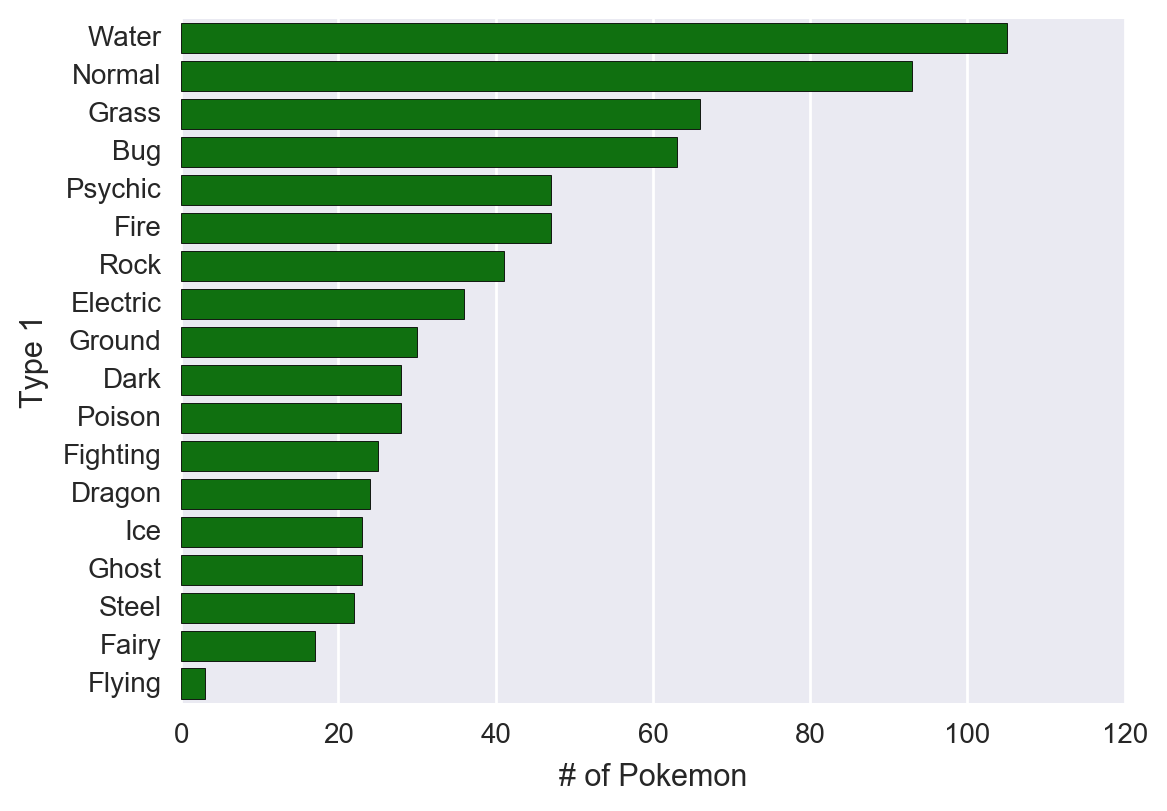

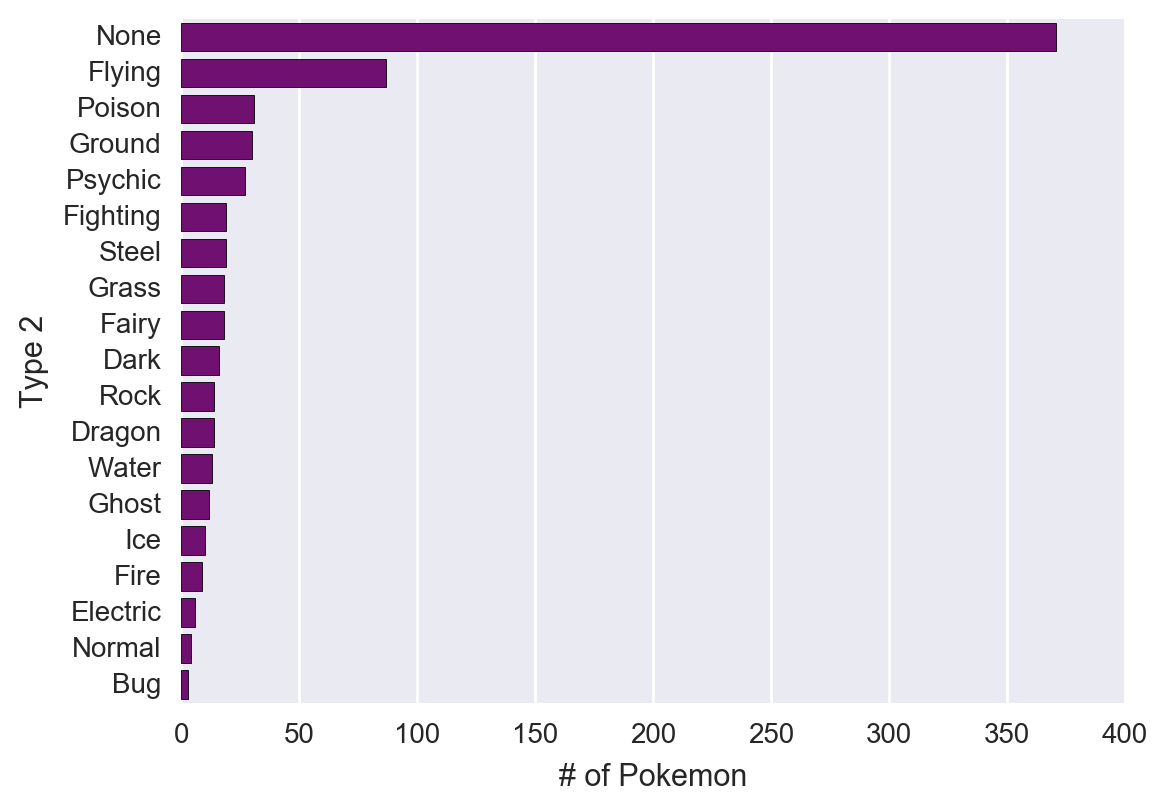

In [16]:
# Set the font scale for better readability 
sns.set_context('notebook')

# Display a categorical histogram of primary types and sort by largest counts
sns.factorplot(
    y='type 1',
    data=pokedex,
    kind='count',
    order=pokedex['type 1'].value_counts().index,
    aspect=1.5,
    color='green'
).set_axis_labels('# of Pokemon', 'Type 1')

# Display a categorical histogram of secondary types and sort by largest counts
sns.factorplot(
    y='type 2',
    data=pokedex,
    kind='count',
    order=pokedex['type 2'].value_counts().index,
    aspect=1.5,
    color='purple'
).set_axis_labels('# of Pokemon', 'Type 2');

We can draw a few conclusions from these plots:
- Nearly half of all Pokemon species only have a primary type.
- Normal-type is a very common primary type and if I remember correctly, this type was considered "generic" back in generation 1 and had mediocre statistics. However, it's surprising that Normal-type Pokemon are outnumbered by Water-type Pokemon; perhaps nowadays Water-type Pokemon are also considered "generic"?
- Nearly 1 in 7 Pokemon species have a secondary Flying-type.
- Pokemon species with Flying-type as their primary type are very rare.

These findings are curious but it'd be more exciting to investigate the distribution of the various combinations of primary and secondary types of Pokemon.

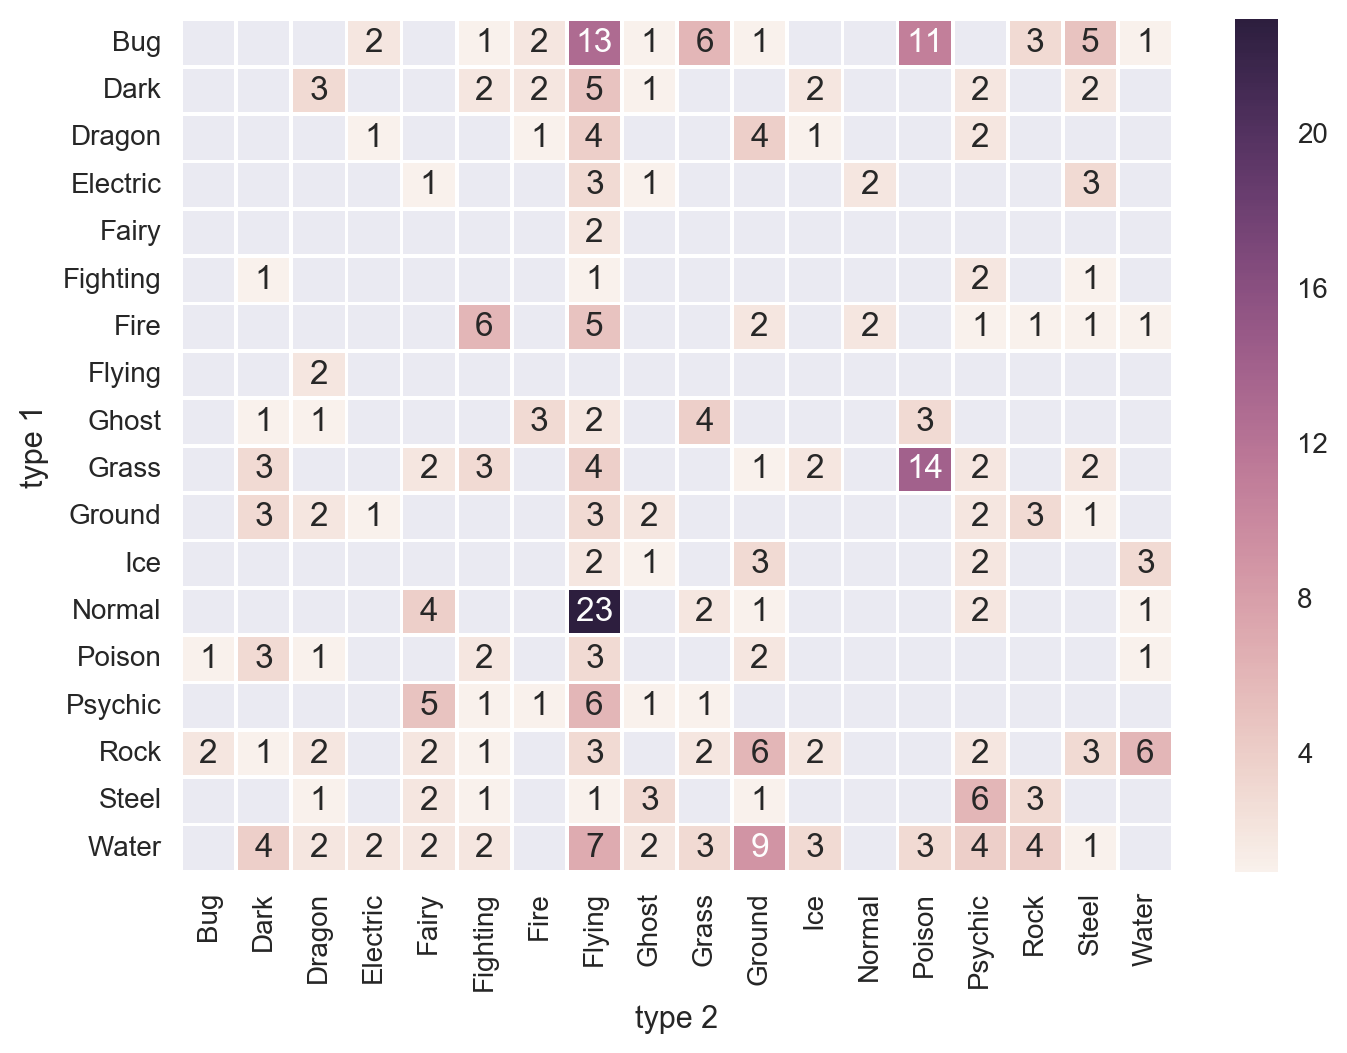

In [17]:
# Exclude Pokemon species without a secondary type to better highlight results
dual_types = pokedex[pokedex['type 2'] != 'None']

# Display a heatmap of the different combinations of primary and secondary types,
# and show the counts for each combination
sns.heatmap(
    dual_types.groupby(['type 1', 'type 2']).size().unstack(),
    linewidths=1,
    annot=True
);

This plot reveals that five most common combinations of primary and secondary type are in order:
1. Normal/Flying-type
2. Bug/Flying-type
3. Bug/Poison-type
4. Grass/Poison-type
5. Water/Ground-type

It would be worth determining if the most common combinations are relatively weaker in order to keep the game balanced (we'll examine this later). I find it paradoxical there actually exist Pokemon species that are Fire/Water-type and Ground/Flying-type! 

Just for kicks, let's take a look at the distribution of types for those Pokemon species that lack a secondary type.

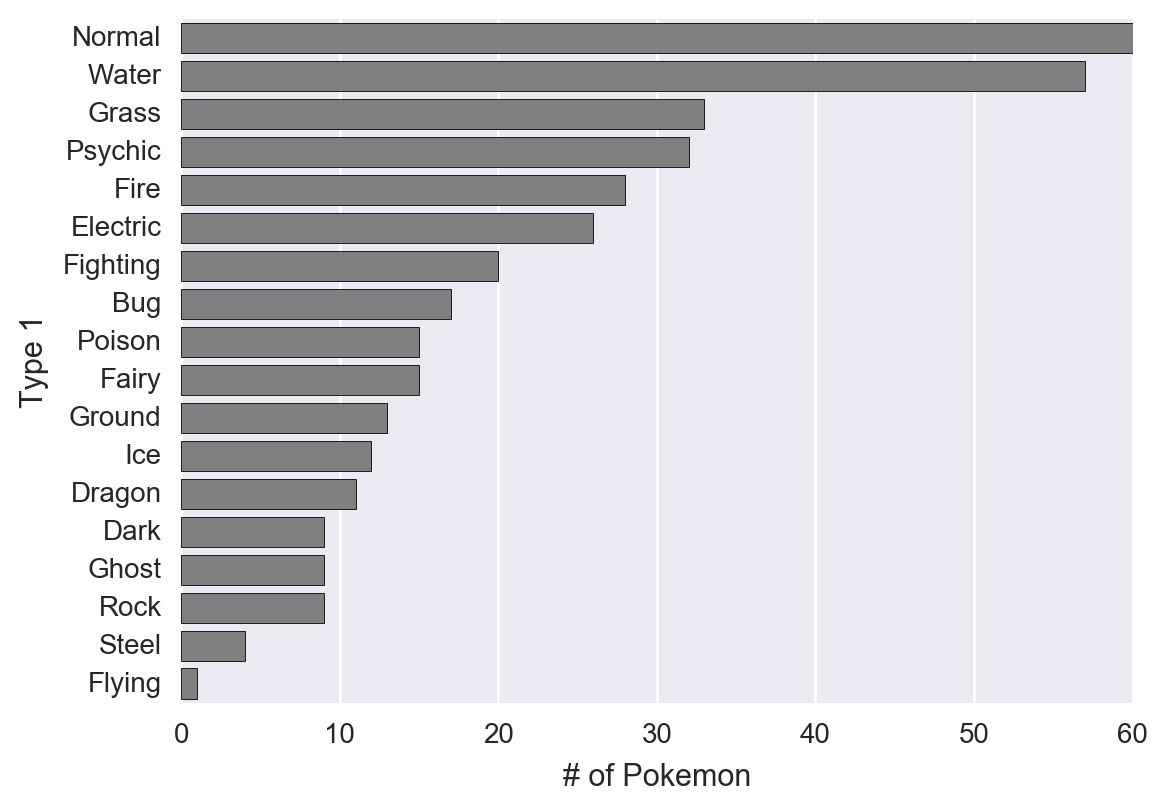

In [18]:
# Select any Pokemon with only a primary type
single_types = pokedex[pokedex['type 2'] == 'None']

# Display a categorical histogram and sort by largest counts
sns.factorplot(
    y='type 1', 
    data=single_types,
    kind='count',
    order=single_types['type 1'].value_counts().index,
    aspect=1.5,
    color='grey'
).set_axis_labels('# of Pokemon', 'Type 1');

Nothing too surprising here besides the considerably large proportion of Pokemon that are only Normal-type or Water-type!

<a id="cell3"></a>
# 4. What are the strongest and weakest Pokemon species?

One potential approach to this question is to rank Pokemon according to the sum of their six statistics. Fortunately, this is already available to us as ```total``` in the ```statistics``` table. Let's use this metric to identify the ten strongest Pokemon.

In [19]:
# Join the statistics table with the pokedex table based on id number to report the 10 
# highest total values
pd.merge(
    pokedex, 
    statistics, 
    on='id'
).sort_values('total', ascending=False).head(10)

,id,name,type 1,type 2,generation,legendary,hp,attack,defense,sp. atk,sp. def,speed,total
492,493,Arceus,Normal,None,4,True,120,120,120,120,120,120,720
643,644,Zekrom,Dragon,Electric,5,True,100,150,120,120,100,90,680
486,487,GiratinaAltered Forme,Ghost,Dragon,4,True,150,100,120,100,120,90,680
249,250,Ho-oh,Fire,Flying,2,True,106,130,90,110,154,90,680
248,249,Lugia,Psychic,Flying,2,True,106,90,130,90,154,110,680
483,484,Palkia,Water,Dragon,4,True,90,120,100,150,120,100,680
642,643,Reshiram,Dragon,Fire,5,True,100,120,100,150,120,90,680
482,483,Dialga,Steel,Dragon,4,True,100,120,120,150,100,90,680
716,717,Yveltal,Dark,Flying,6,True,126,131,95,131,98,99,680
149,150,Mewtwo,Psychic,None,1,True,106,110,90,154,90,130,680


Immediately, we can see that using this metric introduces a major hurdle: at least nine Pokemon are tied for second place with a ```total``` value of 680&mdash;it wouldn't be surprising if there were other ties. Therefore, summing the statistics is not a meaningful way to answer our question. 

Let's try a different metric: standardize the six statistic columns independently by converting each value into a z-score so when we do take the sum, we account for the variation in the each statistic using its mean and standard deviation across all Pokemon species. As a reminder, a [z-score](https://en.wikipedia.org/wiki/Standard_score) is defined by 

$$z = \frac{x-\mu}{\sigma}$$

where ${\mu}$ is the mean and ${\sigma}$ is the standard deviation. We'll define a new column, ```strength```, as the sum of the z-scores of each statistic&mdash;the higher this value, the stronger the Pokemon.

In [20]:
# Generate a new DataFrame to store standardized statistics
std_stats = statistics.copy()

In [21]:
# Standardize each statistic by converting values into a z-score
for s in statistics.loc[:, 'hp':'speed']:
    std_stats[s] = statistics[s].apply(
        lambda x: (x - statistics[s].mean()) / statistics[s].std())

# Compute the strength as the sum of the z-scores for each statistic and store the
# result in a new column
std_stats['strength'] = std_stats.loc[:, 'hp':'speed'].sum(
    axis='columns')

In [22]:
# Join the std_stats table with the pokedex table based on id number to report
# the Pokemon with the 10 highest strength values
pd.merge(
    pokedex, 
    std_stats, 
    on='id'
).sort_values('strength', ascending=False).head(10)

,id,name,type 1,type 2,generation,legendary,hp,attack,defense,sp. atk,sp. def,speed,total,strength
492,493,Arceus,Normal,None,4,True,1.997038,1.543676,1.688730,1.770023,1.889253,1.990097,720,10.878816
486,487,GiratinaAltered Forme,Ghost,Dragon,4,True,3.157657,0.855689,1.688730,1.077948,1.889253,0.890307,680,9.559583
248,249,Lugia,Psychic,Flying,2,True,1.455415,0.511696,2.031255,0.731910,3.153223,1.623500,680,9.507000
249,250,Ho-oh,Fire,Flying,2,True,1.455415,1.887669,0.661154,1.423986,3.153223,0.890307,680,9.471754
715,716,Xerneas,Fairy,None,6,True,2.229161,1.922068,0.832417,2.150665,1.071389,1.220244,680,9.425945
716,717,Yveltal,Dark,Flying,6,True,2.229161,1.922068,0.832417,2.150665,1.071389,1.220244,680,9.425945
149,150,Mewtwo,Psychic,None,1,True,1.455415,1.199683,0.661154,2.946551,0.773985,2.356694,680,9.393482
642,643,Reshiram,Dragon,Fire,5,True,1.223292,1.543676,1.003679,2.808136,1.889253,0.890307,680,9.358342
483,484,Palkia,Water,Dragon,4,True,0.836418,1.543676,1.003679,2.808136,1.889253,1.256904,680,9.338066
383,384,Rayquaza,Dragon,Flying,3,True,1.416728,2.575656,0.661154,2.808136,0.773985,1.073605,680,9.309264


That's more like it! We now have a definitive ranking of the 10 strongest Pokemon species in order: Arceus, Giratina, Lugia, Ho-oh, Xerneas, Yveltal, Mewtwo, Reshiram, Palkia and Rayquaza. Not surprisingly, they're all legendary Pokemon! And even less shocking, [Arceus](http://bulbapedia.bulbagarden.net/wiki/Arceus_(Pok%C3%A9mon) is colloquially known as the "god" Pokemon.

Now let's take a look at the weakest Pokemon.

In [23]:
# Join the std_stats table with the pokedex table based on id number to report
# the Pokemon with the 10 lowest strength values
pd.merge(
    pokedex,
    std_stats,
    on='id'
).sort_values('strength').head(10)

,id,name,type 1,type 2,generation,legendary,hp,attack,defense,sp. atk,sp. def,speed,total,strength
190,191,Sunkern,Grass,None,2,False,-1.484820,-1.552264,-1.393996,-1.344315,-1.456551,-1.309275,180,-8.541221
297,298,Azurill,Normal,Fairy,3,False,-0.711074,-1.896257,-1.051471,-1.690353,-1.084795,-1.675871,190,-8.109822
400,401,Kricketot,Bug,None,4,False,-1.214009,-1.724260,-1.017219,-1.517334,-1.047620,-1.492573,194,-8.013015
264,265,Wurmple,Bug,None,3,False,-0.904510,-1.036274,-1.222734,-1.690353,-1.456551,-1.675871,195,-7.986294
12,13,Weedle,Bug,Poison,1,False,-1.097947,-1.380267,-1.393996,-1.690353,-1.828307,-0.576081,195,-7.966952
9,10,Caterpie,Bug,None,1,False,-0.904510,-1.552264,-1.222734,-1.690353,-1.828307,-0.759379,195,-7.957548
279,280,Ralts,Psychic,Fairy,3,False,-1.562194,-1.724260,-1.565259,-0.825259,-1.270673,-0.942678,198,-7.890324
663,664,Scatterbug,Bug,None,6,False,-1.175321,-1.380267,-1.051471,-1.448127,-1.642429,-1.125976,200,-7.823592
128,129,Magikarp,Water,None,1,False,-1.871693,-2.240250,-0.537684,-1.863372,-1.828307,0.523710,200,-7.817596
348,349,Feebas,Water,None,3,False,-1.871693,-2.068254,-1.736521,-2.036391,-0.527161,0.523710,200,-7.716310


The ten weakest Pokemon are in order: Sunkern, Azurill, Kricketot, Wurmpie, Weedle, Caterpie, Ralts, Scatterbug, Magikarp and Feebas. Interestingly, many of these Pokemon are Bug-type.

It would also be worth identifying the strongest non-legendary Pokemon since these are easier to catch in-game as compared to legendary ones.

In [24]:
# Join the std_stats table with the pokedex table based on id number to report
# the non-legendary Pokemon with the 10 highest strength values
pd.merge(
    pokedex[~pokedex['legendary']],
    std_stats,
    on='id'
).sort_values('strength', ascending=False).head(10)

,id,name,type 1,type 2,generation,legendary,hp,attack,defense,sp. atk,sp. def,speed,total,strength
277,289,Slaking,Normal,None,3,False,3.157657,2.919649,1.003679,0.904929,-0.155405,1.256904,670,9.087412
658,706,Goodra,Dragon,None,6,False,0.836418,0.855689,-0.023896,1.423986,3.004521,0.523710,600,6.620428
423,445,Garchomp,Dragon,Ground,4,False,1.532790,1.887669,0.832417,0.385873,0.588107,1.330223,600,6.557078
599,635,Hydreigon,Dark,Dragon,5,False,0.913793,1.027686,0.661154,1.943042,0.773985,1.183584,600,6.503244
361,373,Salamence,Dragon,Flying,3,False,1.029855,2.059666,0.318629,1.423986,0.402229,1.256904,600,6.491268
145,149,Dragonite,Dragon,Flying,1,False,0.875106,2.025266,0.832417,1.077948,1.145741,0.523710,600,6.480187
239,248,Tyranitar,Rock,Dark,2,False,1.223292,2.025266,1.346204,0.904929,1.145741,-0.172824,600,6.472608
364,376,Metagross,Steel,Psychic,3,False,0.449545,2.059666,2.031255,0.904929,0.773985,0.157113,600,6.376493
531,567,Archeops,Rock,Flying,5,False,0.256109,2.231662,-0.195159,1.493193,-0.155405,1.623500,567,5.253901
236,242,Blissey,Normal,None,2,False,7.219824,-2.240250,-2.079047,0.212854,2.446887,-0.392782,540,5.167485


The five strongest non-legendary Pokemon are in order: Slaking, Goodra, Garchomp, Hyregion, Salamence, Dragonite, Tyranitar, Metagross, Archeops and Blissey. Slaking commands a strong lead. Regardless, many of these are Dragon-type Pokemon. Very intriguing!

<a id="cell4"></a>
# 5. What are the strongest and weakest types of Pokemon?

Since our last analysis hinted that certain types of Pokemon may be stronger than others, let's take a look at the strongest combinations of primary and secondary types. In addition, instead of using the mean as a measure of central tendency and assuming the strengths of each type are normally distributed, let's use the median.

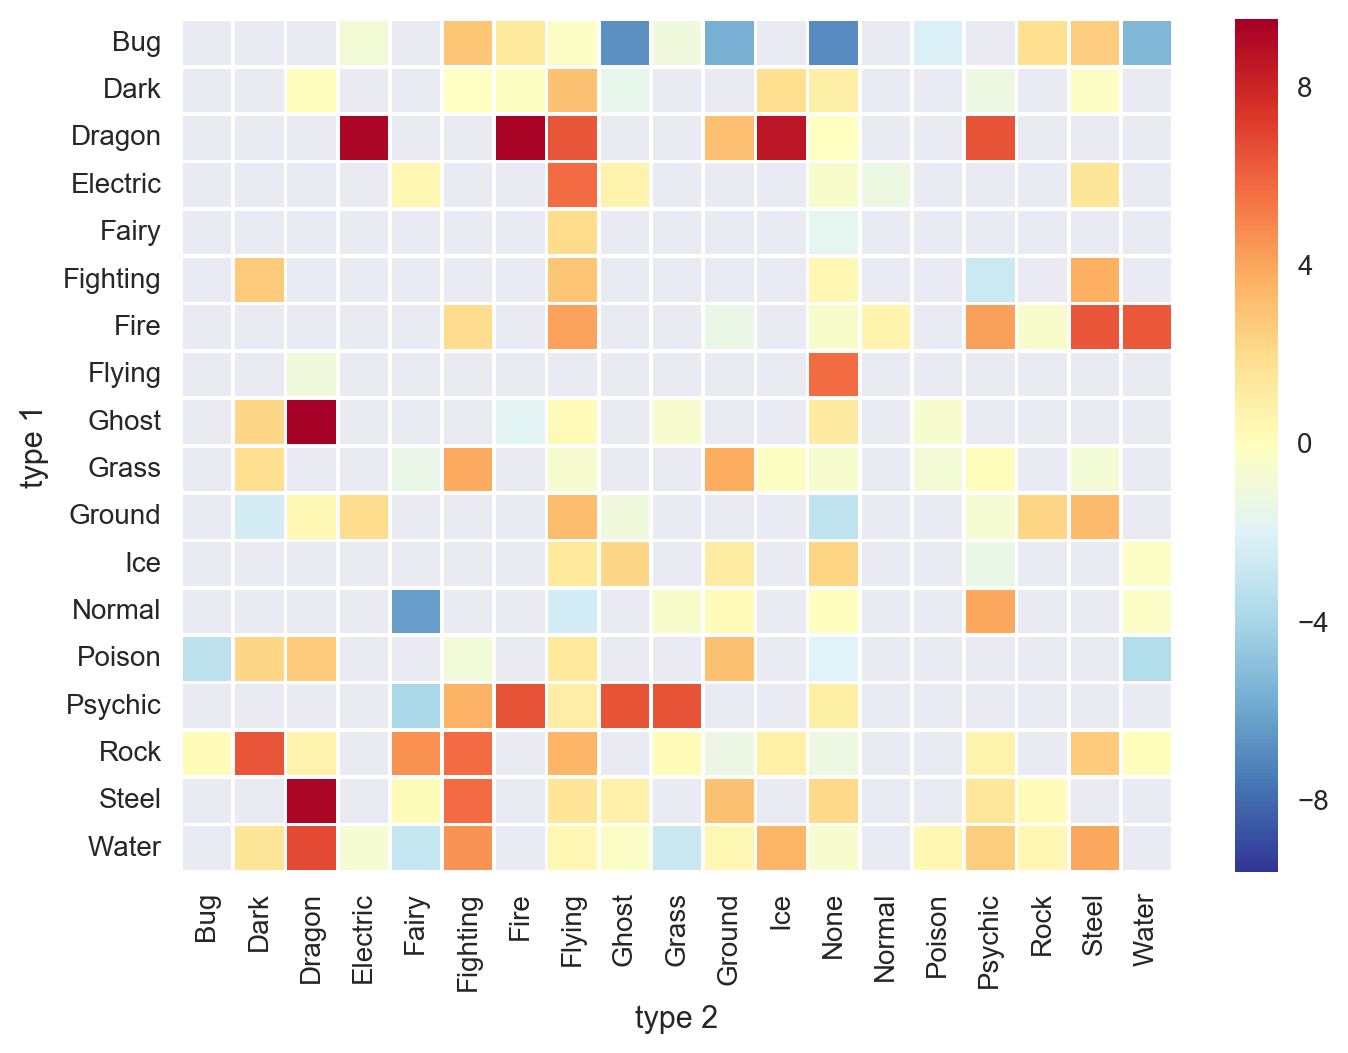

In [25]:
# Join the std_stats table with the pokedex table based on id number
joined = pd.merge(
    pokedex,
    std_stats,
    on='id'
)

# Calculate the median strength of each combination of primary and secondary type
medians = joined.groupby(['type 1', 'type 2']).median().loc[:, 'strength']

# Display a heatmap of the median strength of each combination of primary and
# secondary type
sns.heatmap(
    medians.unstack(),
    linewidths=1,
    cmap='RdYlBu_r'
);

The heatmap is teeming with information but it's difficult to rank the strongest combinations of primary and secondary types. Let's identify the top five directly.

In [26]:
# Rearrange the medians table and sort by the strongest combination of primary and 
# secondary types
medians.reset_index().sort_values('strength', ascending=False).head()

,type 1,type 2,strength
53,Ghost,Dragon,9.559583
22,Dragon,Fire,9.358342
119,Steel,Dragon,9.299880
21,Dragon,Electric,9.293747
25,Dragon,Ice,8.702948


We can draw a few conclusions from these data:
- The five strongest combinations of primary and secondary types are in order: Ghost/Dragon, Dragon/Fire, Steel/Dragon, Dragon/Electric and Dragon/Ice.
- Among the strongest Pokemon are some primary Psychic-types, secondary  Fighting-types and secondary Flying-types.
- The strongest Pokemon tend to have Dragon-type as either their primary or secondary type, and among the weakest Pokemon are primary Bug-types. Our suspicions are confirmed!

Since legendary Pokemon species are a) rare and b) typically vastly stronger than non-legendary Pokemon, the former group may be confounding our results. Therefore, let's perform the same analysis as above without legendary Pokemon, and then list the strongest combinations.

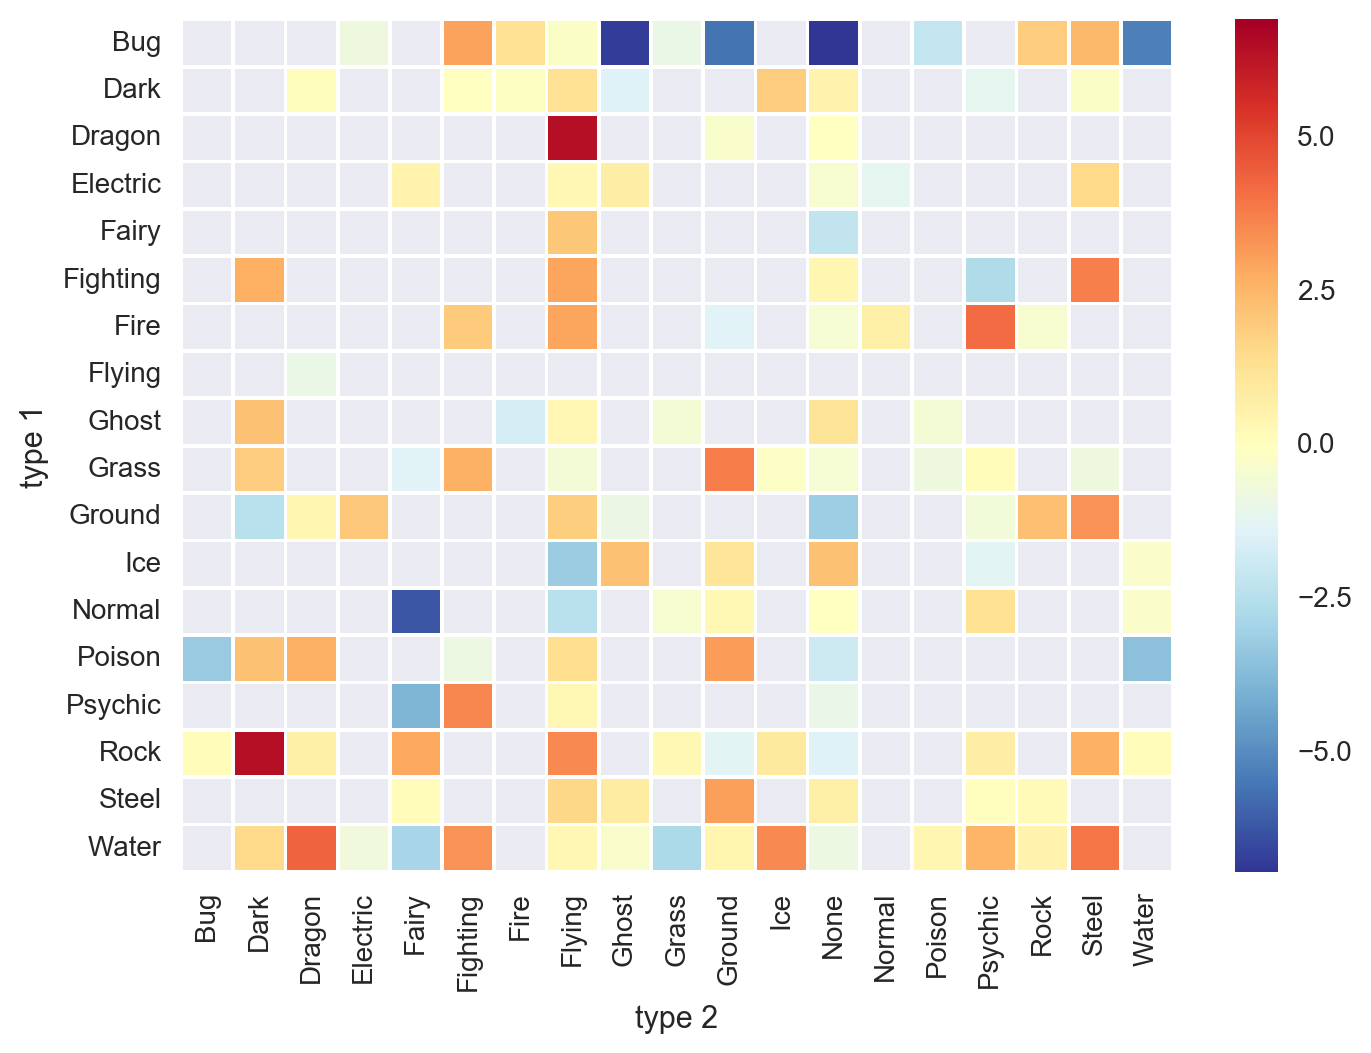

In [27]:
# Join the std_stats table with the pokedex table based on id number for
# non-legendary Pokemon only
joined_nolegs = pd.merge(
    pokedex[~pokedex['legendary']],
    std_stats,
    on='id'
)

# Calculate the median strength of each combination of primary and secondary type
medians = joined_nolegs.groupby(['type 1', 'type 2']).median().loc[:, 'strength']

# Display a heatmap of the median strength of each combination of primary and
# secondary type for non-legendary Pokemon
sns.heatmap(
    medians.unstack(),
    linewidths=1,
    cmap='RdYlBu_r'
);

In [28]:
# Rearrange the medians table and sort by the strongest combination of primary and 
# secondary types for non-legendary Pokemon
medians.reset_index().sort_values('strength', ascending=False).head()

,type 1,type 2,strength
21,Dragon,Flying,6.480187
96,Rock,Dark,6.472608
115,Water,Dragon,4.344018
42,Fire,Psychic,4.201712
128,Water,Steel,4.003064


The results change a bit when excluding legendary Pokemon: Dragon-type is not as dominating; in fact, there's more diversity in strength among the different types. This also indicates that many legendary Pokemon species are Dragon-type, and the game maintains balance by ensuring these Pokemon are a lot less common. Unfortunately for Bug-type Pokemon, even though they're the fourth most common primary type, they're still among the weakest of all.

Our earlier analysis pointed out the most common combination of primary and secondary types: Normal/Flying, Bug/Flying, Bug/Poison, Grass/Poison and Water/Ground. If we look at the strength of these combinations, we see that none of them are exceptionally strong or weak&mdash;the game is indeed balanced in this regard!

<a id="cell5"></a>
# 6. Do any types of Pokemon excel at certain statistics over others?

We've seen that a Pokemon's type can influence how strong it is. Now let's investigate if any specific statistic is driving these results and whether different types of Pokemon excel at a particular statistic. Since all Pokemon have a primary type, let's restrict our analysis to primary types only.

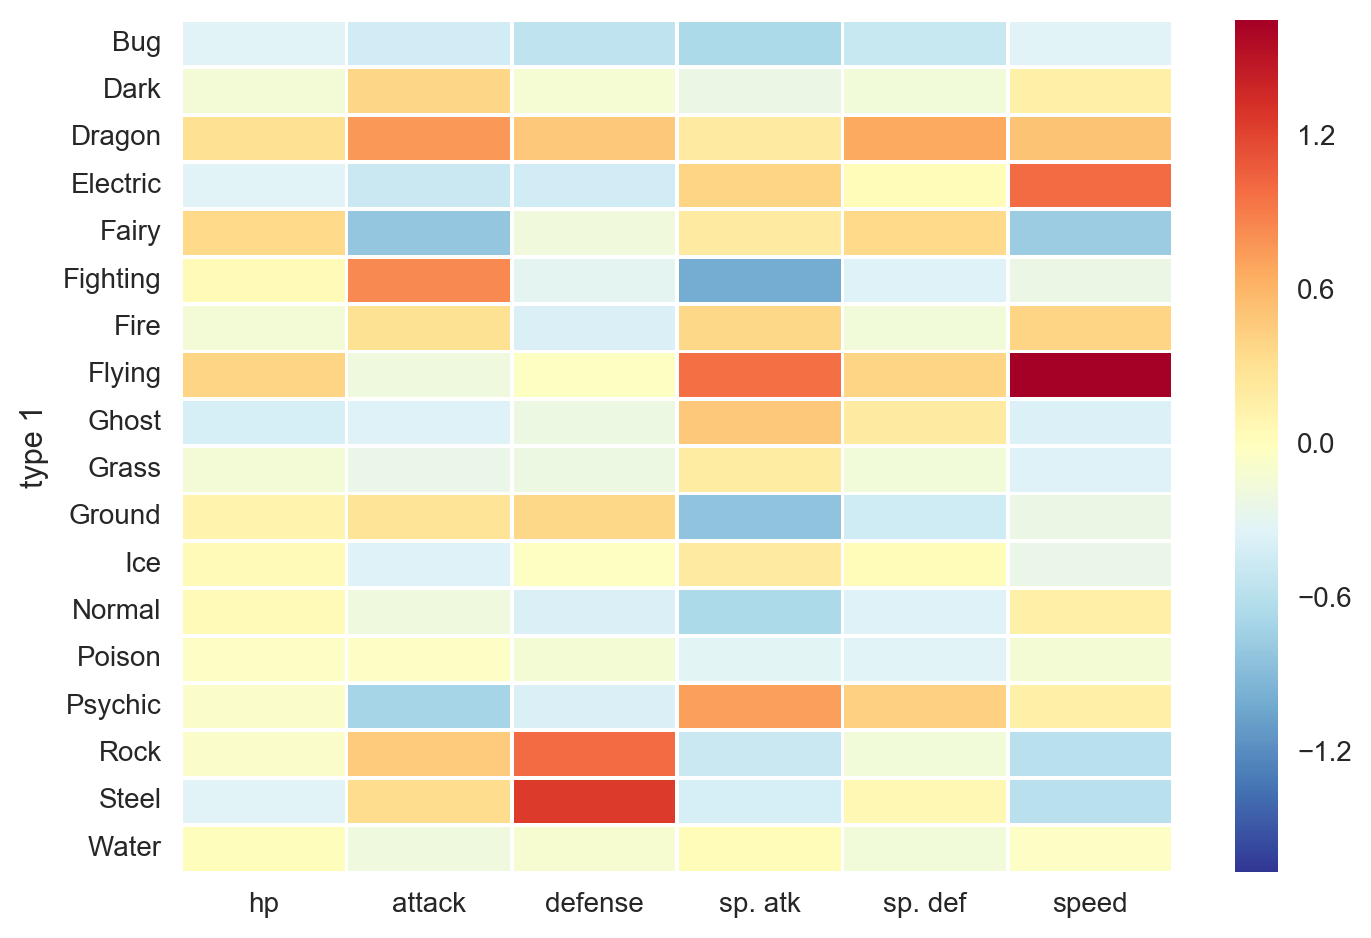

In [29]:
# Display a heatmap of the distribution of statistics across primary types
sns.heatmap(
    joined.groupby('type 1').median().loc[:, 'hp':'speed'], 
    linewidths=1,
    cmap='RdYlBu_r'
);

We can draw a few conclusions from these data:
- Flying-type Pokemon are really fast, which makes intuitive sense.
- Among the Pokemon with the highest defense are Rock- or Steel-type Pokemon. There is method to the madness after all!

Again, since including legendary Pokemon species may be potentially concealing some interesting tidbits, let's take a look at the same analysis but exclude legendary Pokemon.

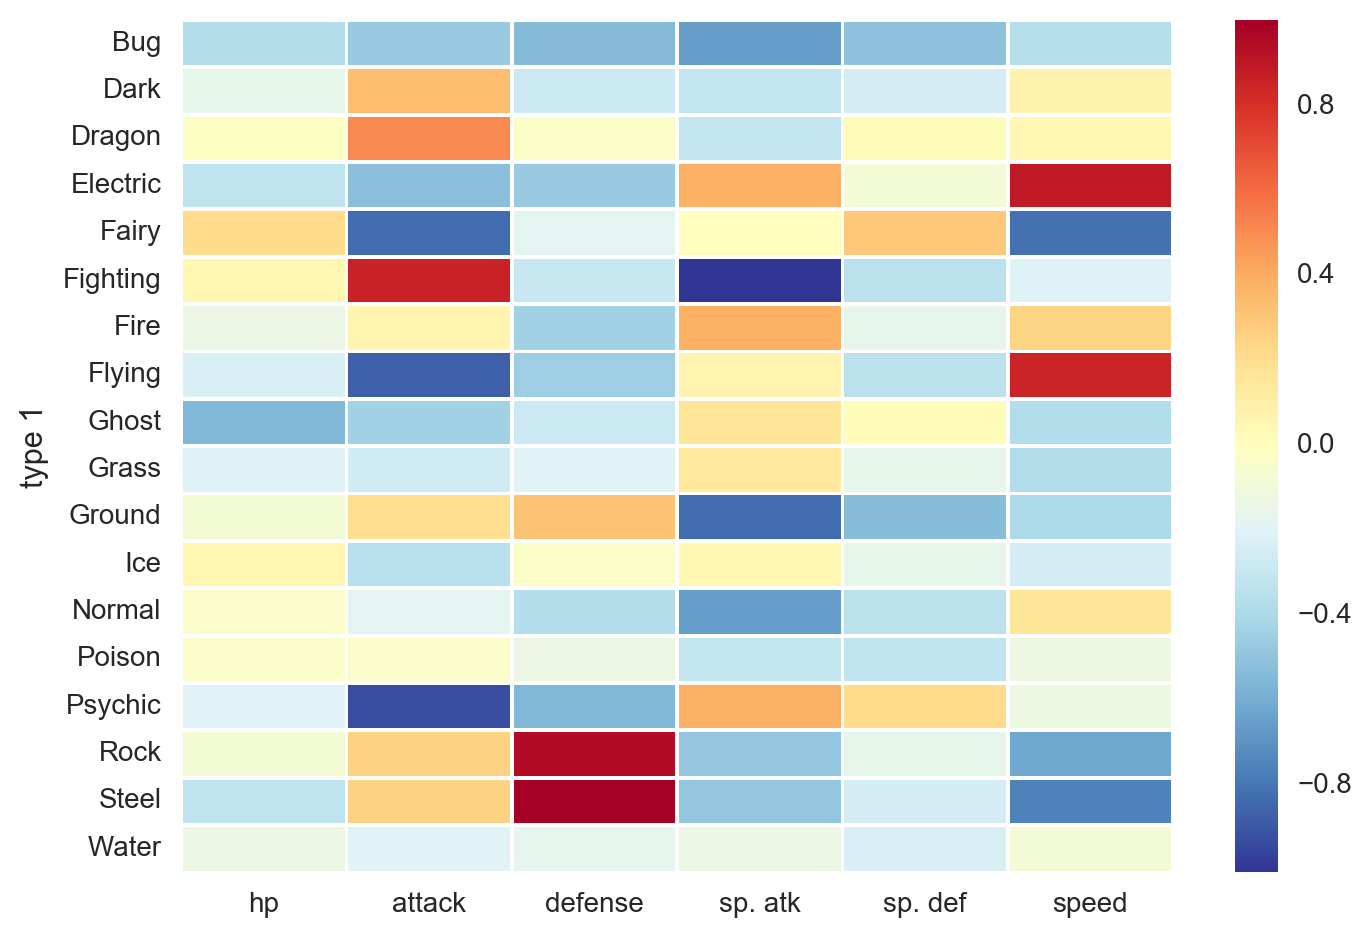

In [30]:
# Display a heatmap of the distribution of statistics across primary types
# for non-legendary Pokemon
sns.heatmap(
    joined_nolegs.groupby('type 1').median().loc[:, 'hp':'speed'], 
    linewidths=1,
    cmap='RdYlBu_r'
);

It looks like we can gain more insight into this data by leaving out legendary Pokemon:
- The fastest Pokemon are Flying-type or Electric-type, while Fairy-type, Rock-type or Steel-type are slowpokes.
- Fighting-type Pokemon have unparalleled attack power but the worst special attack power.
- Psychic-type, Flying-type and Fairy-type Pokemon have abysmal attack power. The former two at least make it up by excelling elsewhere.
- No type of Pokemon have standout HP or special defense.
- Water-type Pokemon have average statistics across the board, which confirms our earlier hunch as they're the most common type of Pokemon. Another good example of the game maintaining balance!
- Rock-type and Steel-type Pokemon still have the absolute best defense but lack in speed. Perhaps there is a correlation between these two statistics?

<a id="cell6"></a>
# 7. Are any of the statistics correlated?

Our findings have hinted certain types of Pokemon that excel at a particular statistic don't fare so well in other statistics. To determine if the statistics are correlated, let's define a function that will compute Pearson's correlation coefficient for each pair of statistics as a measure of the goodness of fit of a linear regression model.

In [31]:
def show_corr(x, y, **kwargs):
    # Calculate Pearson's coefficient for each pair of statistics
    (r, _) = stats.pearsonr(x, y)
    
    # Annotate Pearson's coefficient, rounded to two decimal places, on each 
    # pairwise plot
    ax = plt.gca()
    ax.annotate(
        'r = {:.2f}'.format(r),
        xy=(0.45, 0.85),
        xycoords=ax.transAxes
    )

Since we've already seen examples where the inclusion of legendary Pokemon in the analysis potentially confounds results, let's take a look at the pairwise comparisons of the statistics without legendary Pokemon.

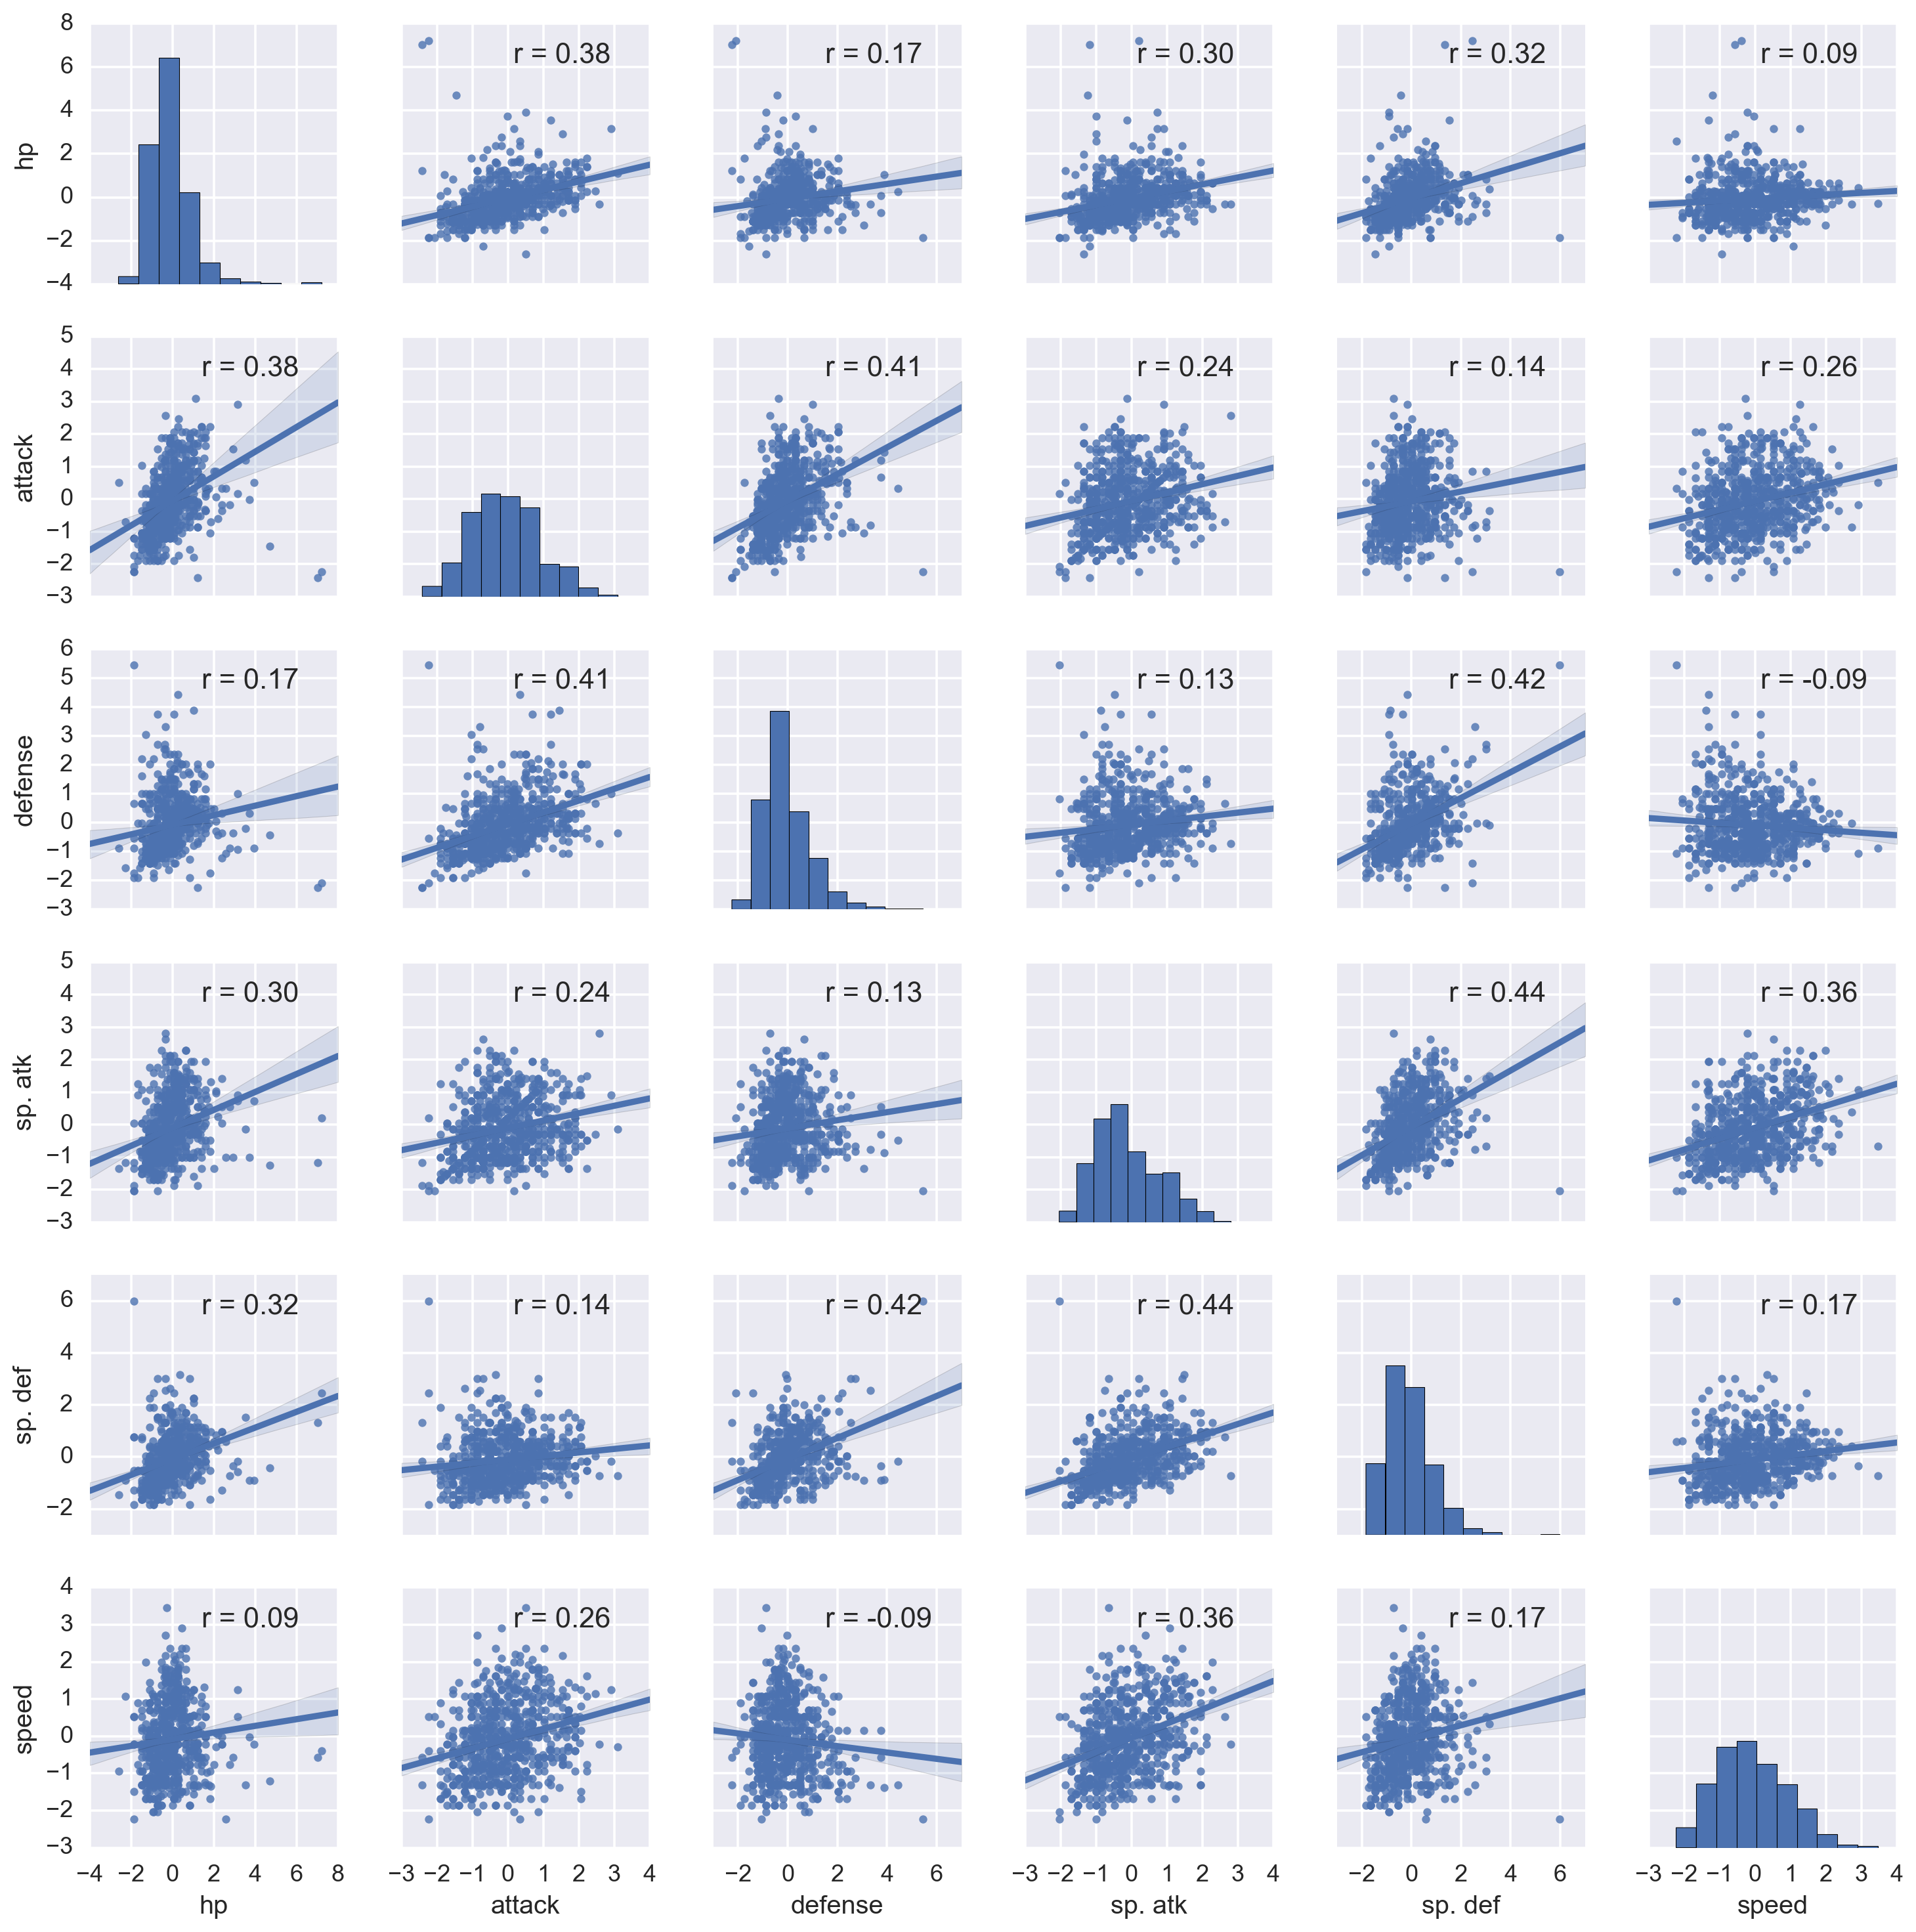

In [32]:
# Set the font scale for better readability 
sns.set_context('talk')

# Show scatterplots with linear regression and Pearson's coefficient for each 
# pair of statistics
sns.pairplot(
    data=joined_nolegs.loc[:, 'hp':'speed'],
    kind='reg'
).map_offdiag(show_corr);

This plot shows that the five most correlated pairs of statistics are in order:
1. special attack/special defense 
2. defense/special defense
3. attack/defense
4. attack/HP
5. special attack/speed

We can see that none of the statistics are strongly correlated, which is actually important as that would favor certain Pokemon or types of Pokemon over others. However, it is worth noting that all of the statistics are positively correlated except for defense and speed&mdash;this particular case is epitomized by Rock-type and Steel-type Pokemon!

The above plot also reveals a few outliers with remarkably high HP, defense or special defense. Let's find out which Pokemon these are.

In [33]:
# Show outliers for the HP statistic
joined_nolegs.loc[joined_nolegs['hp'] > 6, 'name']

112    Chansey
236    Blissey
Name: name, dtype: object

In [34]:
# Show outliers for the defense statistic
joined_nolegs.loc[joined_nolegs['defense'] > 5, 'name']

207    Shuckle
Name: name, dtype: object

In [35]:
# Show outliers for the special defense statistic
joined_nolegs.loc[joined_nolegs['sp. def'] > 5, 'name']

207    Shuckle
Name: name, dtype: object

I remember Chansey having extraordinarily high HP from the original Pokemon games so it's not surprising that Blissey, which is Chansey's evolved form, is up there as well. On a different note, it looks like Shuckle is the most defensive Pokemon by a landslide!

<a id="cell7"></a>
# 8. Considerations regarding the results

Our analysis revealed some wonderful insights about the Pokemon dataset, but it has drawbacks and pitfalls that we must take into account.

## Efficacy of the ```strength``` metric

To determine the strongest Pokemon, we summed up the standardized statistics for each species. While this is better than ```total```, we still made a critical assumption: each statistic was weighted equally. In the real world, some gamers like to focus on defense to win battles, while others will take advantage of speed or use brute force&mdash;it's simply a matter of taste. While our metric approached Pokemon strength objectively as possible, in the end, it may not be meaningful to all players.

In addition, the Pokemon games add another layer of complexity for determining success in battles: the Pokemon's move list. These moves also have their own types (e.g., Fire Blast is a Fire-type move). Each type of move can be more, less or not effective at all depending on the type of Pokemon it has targeted. Moreover, whether a move is successfully executed by a Pokemon has a luck component. Therefore, the player's selection of moves during the battle is ultimately a bigger factor in determining success than the strength of the Pokemon chosen.

Finally, the statistics found in the dataset refer to base values. As a Pokemon levels up and wins battles, the statistics grow. Unfortunately, these statistics grow at different rates. To make things even more convoluted, certain Pokemon naturally excel at specific statistics.

## Secret of the heatmaps

The heatmaps displaying the strongest and weakest types of Pokemon were incredibly informative. However, they conceal the number of Pokemon representing a given combination of primary and secondary type. This is important in scenarios where there exist only one or two Pokemon for a particular combination. For example, let's take a look at the unequivocally strongest type of Pokemon: Ghost/Dragon. 

In [36]:
pokedex[(pokedex['type 1'] == 'Ghost') & (pokedex['type 2'] == 'Dragon')]

,id,name,type 1,type 2,generation,legendary
544,487,GiratinaAltered Forme,Ghost,Dragon,4,True


It looks like Giratina is the one and only Ghost/Dragon-type Pokemon, and it's also a rare legendary Pokemon! On the other hand, let's take a look at the strongest type of non-legendary Pokemon: Dragon/Flying.

In [37]:
pokedex[(pokedex['type 1'] == 'Dragon') & (pokedex['type 2'] == 'Flying')]

,id,name,type 1,type 2,generation,legendary
161,149,Dragonite,Dragon,Flying,1,False
365,334,Altaria,Dragon,Flying,3,False
408,373,Salamence,Dragon,Flying,3,False
425,384,Rayquaza,Dragon,Flying,3,True


There's more choices available with Dragon/Flying-type Pokemon as compared to Ghost/Dragon-type&mdash;not to mention three of them are non-legendary and relatively easier to capture. Therefore, one can see that when determining Pokemon strength, it quickly boils to down being quite subjective. However, if there was a single best Pokemon or type of Pokemon, everyone would naturally gravitate towards it. By adding nuance to the system, the developers have made Pokemon a game that is more than simply optimizing statistics and strength, but a tactical and personal experience. No wonder they've sold nearly 300 million copies!

This exercise was a fun way to become familiar with pandas and seaborn, and I can already think of ways to use machine learning to answer questions such as:

- Can we identify a Pokemon's type solely by its photo?
- Can a machine classify the newly released Pokemon in generation 7?

If you want to play around with the code or run the analysis yourself, here's the [GitHub repository](https://github.com/redwanhuq/pokemon-analysis). Don't hesitate to leave your comments below, especially if you can think of other interesting questions to answer using this dataset!